In [1]:
# !pip install -q opendatasets tensorflow_hub
# import opendatasets as od

import os
import datetime
import time

from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import itertools

!pip install -q tensorflow_addons

import tensorflow as tf
from tensorflow_addons.layers import InstanceNormalization
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential, backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Input, Concatenate, concatenate
from tqdm import tqdm

gpus = tf.config.list_physical_devices('GPU')
print("GPU available: ", gpus)

GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# od.download("https://www.kaggle.com/ktaebum/anime-sketch-colorization-pair")
# !rm -r anime-sketch-colorization-pair/data/data
# !rm -r anime-sketch-colorization-pair/data/colorgram

In [4]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img

In [5]:
def split_image(image):
    w = tf.shape(image)[1]
    w = w // 2
    sketch_image = image[:, :w, :]
    colored_image = image[:, w:, :]
    sketch_image = tf.image.resize(sketch_image, (256, 256))
    colored_image = tf.image.resize(colored_image, (256, 256))
    return sketch_image, colored_image

In [6]:
def flip_image(image):
    return tf.image.flip_left_right(image)

def random_jitter(sketch_image, colored_image):

    if tf.random.uniform(()) > 0.5:
        sketch_image = flip_image(sketch_image)
        colored_image = flip_image(colored_image)

    return sketch_image, colored_image

In [7]:
def normalize_symmetric(sketch_image, colored_image):
    sketch_image = tf.cast(sketch_image, tf.float32)/127.5 - 1
    colored_image = tf.cast(colored_image, tf.float32)/127.5 - 1
    return sketch_image, colored_image

def normalize_zero_to_one(sketch_image, colored_image):
    sketch_image = tf.cast(sketch_image, tf.float32)/255
    colored_image = tf.cast(colored_image, tf.float32)/255
    return sketch_image, colored_image

In [8]:
def image_loader(train=False, normalization_fn=normalize_zero_to_one):
    def load_image(image_path):
        image = read_png(image_path)
        colored_image, sketch_image = split_image(image)
        sketch_image, colored_image = normalization_fn(sketch_image, colored_image)
        
        if train:
            sketch_image, colored_image = random_jitter(sketch_image, colored_image)

        return sketch_image, colored_image

    return load_image

In [9]:
def show_n(images, titles=('',)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]
    w = (image_sizes[0] * 6) // 320
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]), aspect='equal')
        plt.axis('off')
        plt.title(titles[i] if len(titles) > i else '')
    plt.show()

In [10]:
nsamples = 5000

In [11]:
train_path = './anime-sketch-colorization-pair/data/train/'
train_images_path = [os.path.join(train_path, image_name) for image_name in os.listdir(train_path)]

train_images_path = train_images_path[:nsamples]
print(f'Training samples = {len(train_images_path)}')

test_path = './anime-sketch-colorization-pair/data/val/'
test_images_path = [os.path.join(test_path, image_name) for image_name in os.listdir(test_path)]
print(f'Test samples = {len(test_images_path)}')

Training samples = 5000
Test samples = 3545


In [12]:
BATCH_SIZE = 16
BUFFER_SIZE = 400

In [13]:
def get_image(color=False, train=True, normalization_fn=normalize_symmetric):
    def fn(image_path):
        return image_loader(train, normalization_fn)(image_path)[color]
    return fn

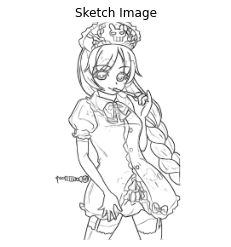

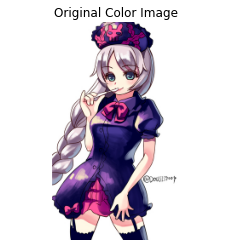

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_path)
train_sketches = train_dataset.map(get_image(), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)
train_colors = train_dataset.map(get_image(color=True), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

sample_sketch = next(itertools.islice(iter(train_sketches), 4, 5))
show_n([sample_sketch[0]], titles=['Sketch Image'])
    
sample_color = next(itertools.islice(iter(train_colors), 4, 5))
show_n([sample_color[0]], titles=['Original Color Image'])

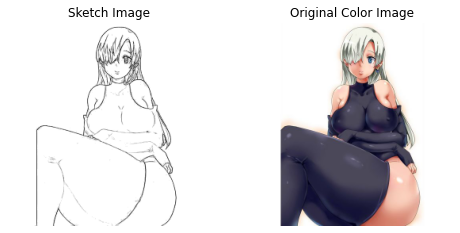

In [15]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_images_path)
test_dataset = test_dataset.map(image_loader(train=False, normalization_fn=normalize_symmetric))
test_dataset = test_dataset.batch(BATCH_SIZE)

for sketches, colors in test_dataset.take(1):
    show_n([sketches[0], colors[0]], titles=['Sketch Image', 'Original Color Image'])

In [16]:
def downsample(filters, size, apply_batchnorm=True):
    block = Sequential()
    block.add(Conv2D(filters, size, strides=2, padding='same', use_bias=False))

    if apply_batchnorm:
        block.add(InstanceNormalization())
        
    block.add(LeakyReLU())

    return block

def upsample(filters, size, apply_dropout=False):
    block = Sequential()
    block.add(Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))
    block.add(InstanceNormalization())

    if apply_dropout:
        block.add(Dropout(0.5))

    block.add(ReLU())

    return block

In [17]:
def Generator():
    inp = Input(shape=[256,256,3])
    x = inp
    
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    bottleneck = downsample(512, 4)
    # decoder stack
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    last_layer = Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', activation='tanh')
    
    # Downsampling
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    x = bottleneck(x)
    skips.reverse()

    # Upsampling + creating skip connections for the i-th encoder and (n-i)-th decoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last_layer(x)

    return Model(inputs=inp, outputs=x)

In [18]:
def Discriminator():
    inp = Input(shape=[256, 256, 3], name='sketch_image')

    x = inp
    
    block_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4)
    ]
    
    last_layer = Conv2D(1, 4, strides=1, padding='same')
    
    for block in block_stack:
        x = block(x)
    
    x = last_layer(x)

    return Model(inputs=inp, outputs=x)

In [19]:
OUTPUT_CHANNELS = 3

generator_g = Generator()
generator_f = Generator()

discriminator_x = Discriminator()
discriminator_y = Discriminator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


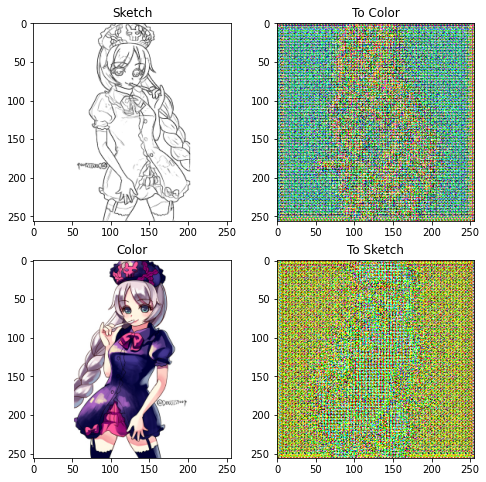

In [20]:
to_color = generator_g(sample_sketch)
to_sketch = generator_f(sample_color)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_sketch, to_color, sample_color, to_sketch]
title = ['Sketch', 'To Color', 'Color', 'To Sketch']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [21]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [23]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [24]:
LAMBDA = 5
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [25]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.01 * loss

In [26]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/cycle_gan")


checkpoint_path = "./tf_ckpts/cycle_gan"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [28]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    
    return gen_g_loss, gen_f_loss, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [29]:
epoch_loss_avg_gen_g_loss = tf.keras.metrics.Mean('gen_g_loss')
epoch_loss_avg_gen_f_loss = tf.keras.metrics.Mean('gen_f_loss')

epoch_loss_avg_total_cycle_loss = tf.keras.metrics.Mean('total_cycle_loss')

epoch_loss_avg_total_gen_g_loss = tf.keras.metrics.Mean('total_gen_g_loss')
epoch_loss_avg_total_gen_f_loss = tf.keras.metrics.Mean('total_gen_f_loss')

epoch_loss_avg_disc_x_loss = tf.keras.metrics.Mean('disc_x_loss')
epoch_loss_avg_disc_y_loss = tf.keras.metrics.Mean('disc_y_loss')

In [30]:
def fit(train_X, train_Y, epochs):
    start = 0
    ckpt.restore(ckpt_manager.latest_checkpoint)
    if ckpt_manager.latest_checkpoint:
        print("Restored from {}".format(ckpt_manager.latest_checkpoint))
        start = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    else:
        print("Initializing from scratch.")
    
    for epoch in range(start + 1, start + epochs + 1):        
        # Using a consistent image (sample_sketch) so that the progress of the model
        # is clearly visible.
        generate_images(generator_g, sample_sketch, sample_color)
        
        print("Epoch: ", epoch)
        
        start = time.time()
        
        for image_x, image_y in tqdm(tf.data.Dataset.zip((train_X, train_Y))):
            gen_g_loss, gen_f_loss, totol_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
            
            epoch_loss_avg_gen_g_loss(gen_g_loss)
            epoch_loss_avg_gen_f_loss(gen_f_loss)
            
            epoch_loss_avg_total_cycle_loss(totol_cycle_loss)
            
            epoch_loss_avg_total_gen_g_loss(total_gen_g_loss)
            epoch_loss_avg_total_gen_f_loss(total_gen_f_loss)
            
            epoch_loss_avg_disc_x_loss(disc_x_loss)
            epoch_loss_avg_disc_y_loss(disc_y_loss)
                
        

        print(f'Time taken: {time.time()-start:.2f} sec')
        print("=====================================================")

        start = time.time()
        
        with summary_writer.as_default():
            tf.summary.scalar('gen_g_loss', epoch_loss_avg_gen_g_loss.result().numpy(), step=epoch)
            tf.summary.scalar('gen_f_loss', epoch_loss_avg_gen_f_loss.result().numpy(), step=epoch)
            tf.summary.scalar('total_cycle_loss', epoch_loss_avg_total_cycle_loss.result().numpy(), step=epoch)
            tf.summary.scalar('total_gen_g_loss', epoch_loss_avg_total_gen_g_loss.result().numpy(), step=epoch)
            tf.summary.scalar('total_gen_f_loss', epoch_loss_avg_total_gen_f_loss.result().numpy(), step=epoch)
            tf.summary.scalar('disc_x_loss', epoch_loss_avg_disc_x_loss.result().numpy(), step=epoch)
            tf.summary.scalar('disc_y_loss', epoch_loss_avg_disc_y_loss.result().numpy(), step=epoch)
    
        
        epoch_loss_avg_gen_g_loss.reset_states()
        epoch_loss_avg_gen_f_loss.reset_states()
        epoch_loss_avg_total_cycle_loss.reset_states()
        epoch_loss_avg_total_gen_g_loss.reset_states()
        epoch_loss_avg_total_gen_f_loss.reset_states()
        epoch_loss_avg_disc_x_loss.reset_states()
        epoch_loss_avg_disc_y_loss.reset_states()
        
        saved_path = ckpt_manager.save()
        print("Saved checkpoint for epoch {}: {}".format(int(epoch), saved_path))

In [31]:
def generate_images(model, sketch, color):
    prediction = model(sketch, training=False)
    show_n([sketch[0], color[0], prediction[0]], titles=['Sketch Image', 'Original Color Image', 'Generated Image'])

In [32]:
fit(train_sketches, train_colors, 0)

Restored from ./tf_ckpts/cycle_gan/ckpt-20


In [33]:
# %reload_ext tensorboard
# %tensorboard --logdir logs

# !kill 250

In [34]:

# !rm -r logs/fit/cycle_gan
# !rm -r tf_ckpts/cycle_gan
# !rm -r generator_weights/cycle_gan

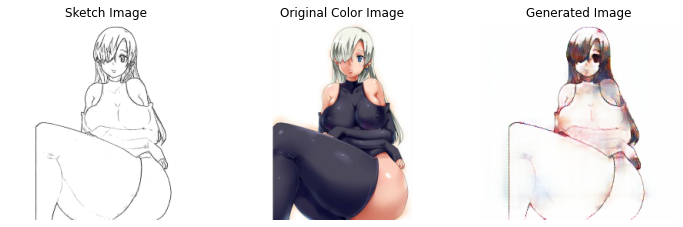

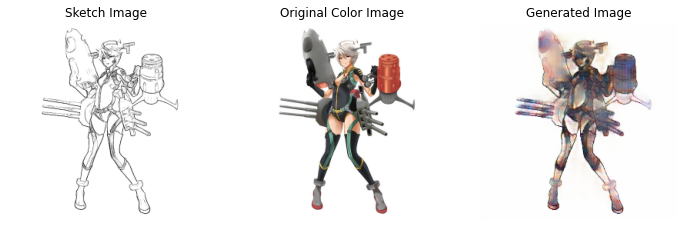

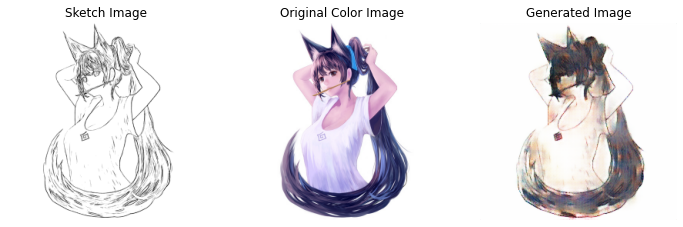

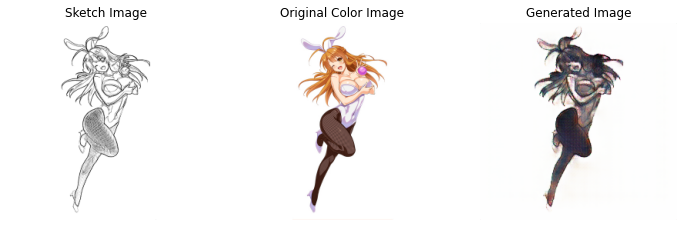

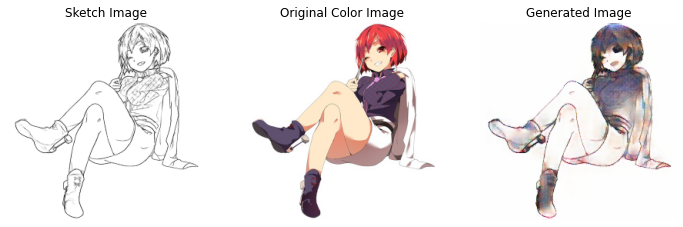

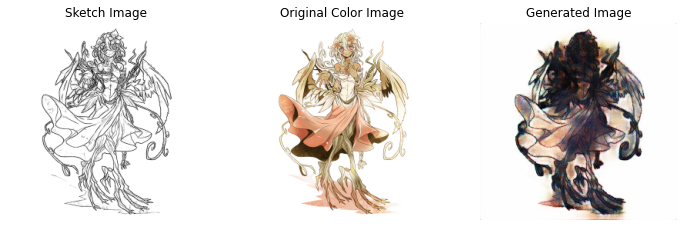

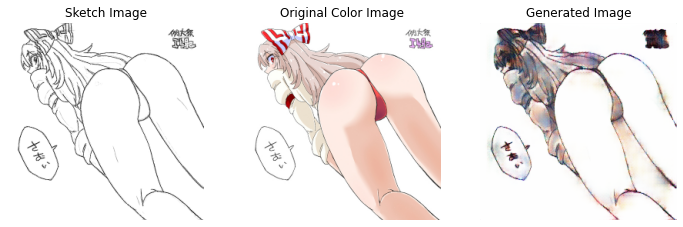

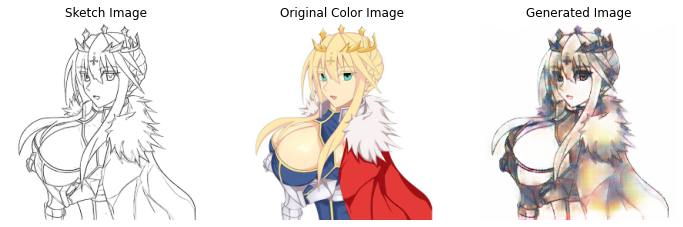

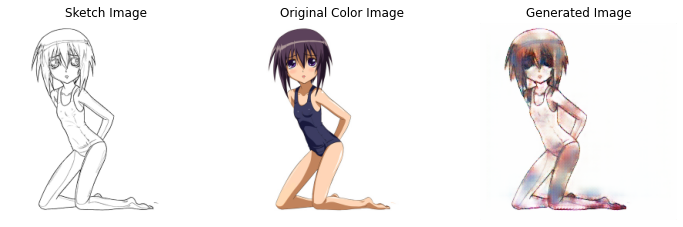

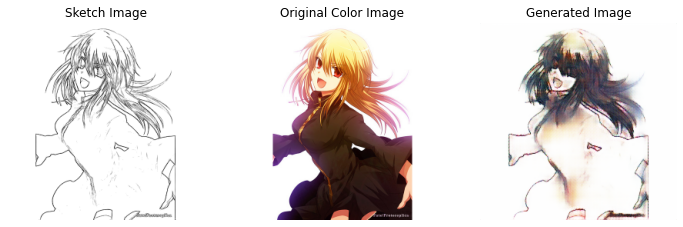

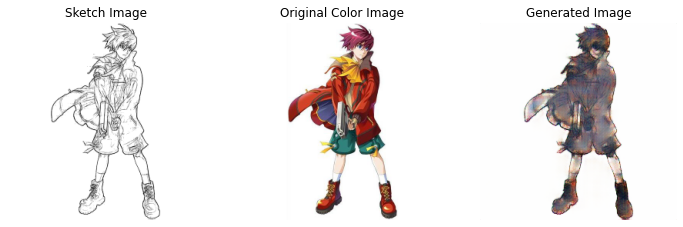

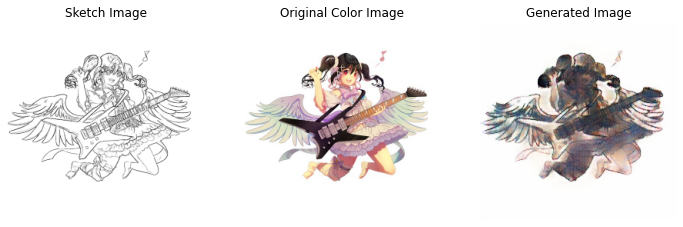

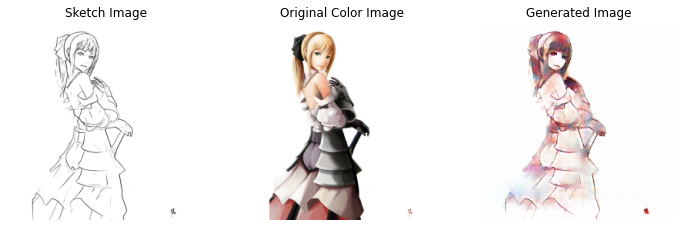

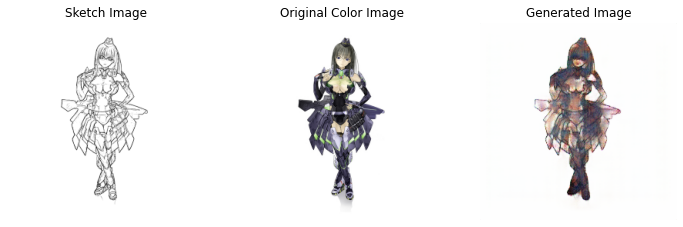

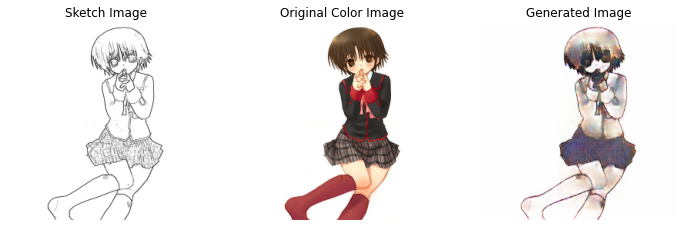

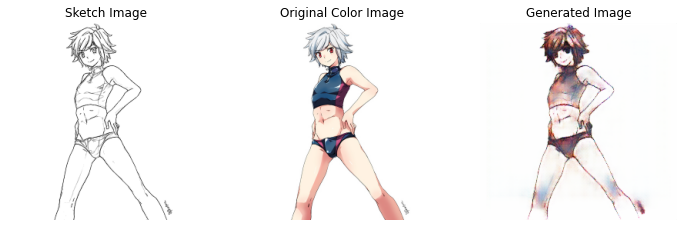

In [35]:
for example_inputs, example_targets in test_dataset.take(1):
    for i in range(len(example_inputs)):
        generate_images(generator_g, example_inputs[i:i+1], example_targets[i:i+1])

In [36]:
mae = 0
for i, (sketches, colors) in tqdm(test_dataset.enumerate()):
    generated = generator_g.predict(sketches, verbose=0)
    loss = tf.reduce_mean(tf.abs(colors - generated))
    mae += loss
print(f'avg mae = {mae / len(test_dataset)}')

100%|██████████| 222/222 [00:34<00:00,  6.38it/s]

avg mae = 0.22357608377933502


avg mae = 0.22357608377933502

In [37]:
ssim = 0
for i, (sketches, colors) in tqdm(test_dataset.enumerate(29)):
    generated = generator_g.predict(sketches, verbose=0)
    loss = tf.reduce_mean(tf.image.ssim(generated, colors, 255))
    ssim += loss
print(f'avg ssim = {ssim / len(test_dataset)}')

100%|██████████| 222/222 [00:35<00:00,  6.18it/s]

avg ssim = 0.9757318496704102


avg ssim = 0.9757318496704102

In [38]:
from scipy import linalg

def calculate_fid(real, generated):
    fid = 0
    num = len(real)
    for index in range(num):
        temp_fid = 0
        for i in range(3):
            # calculate mean and covariance statistics
            mu1, sigma1 = real[index].mean(axis=0), np.cov(real[index][:,:,i], rowvar=False)
            mu2, sigma2 = generated[index].mean(axis=0), np.cov(generated[index][:,:,i], rowvar=False)

            # calculate sum squared difference between means
            ssdiff = np.sum((mu1 - mu2)**2.0)

            # calculate sqrt of product between cov
            covmean = linalg.sqrtm(sigma1.dot(sigma2))

            # check and correct imaginary numbers from sqrt
            if np.iscomplexobj(covmean):
                covmean = covmean.real

            # calculate score
            temp_fid += ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        fid += temp_fid / 3
    return fid/num

In [ ]:
fid = 0
for i, (sketches, colors) in tqdm(test_dataset.enumerate()):
    generated = generator_g.predict(sketches, verbose=0)
    fid += calculate_fid(colors.numpy(), generated)
print(f'avg fid = {fid / len(test_dataset)}')

 92%|█████████▏| 205/222 [12:31<01:10,  4.12s/it]